# Advanced Techniques


In this course, we will explore techniques to improve the reliability and ease of training neural networks.
To illustrate these techniques, we use the [MNIST](https://fr.wikipedia.org/wiki/Base_de_donn%C3%A9es_MNIST) dataset, which contains images of handwritten digits from 1 to 9.
The goal is to make the network take an image as input and identify the digit it represents.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

## Creating the Dataset


To begin, we download the MNIST dataset. The torchvision library allows managing images with PyTorch and provides tools to load common datasets.


In [4]:
transform=T.ToTensor() # Pour convertir les éléments en tensor torch directement
dataset = datasets.MNIST(root='./../data', train=True, download=True,transform=transform)
test_dataset = datasets.MNIST(root='./../data', train=False,transform=transform)

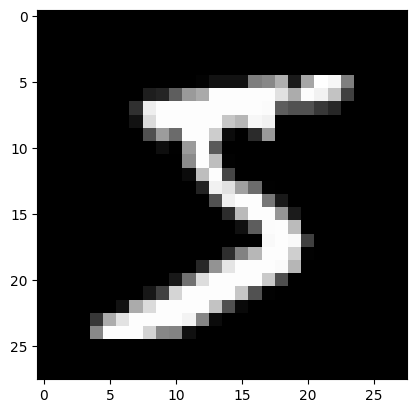

Le chiffre sur l'image est un 5


In [5]:
# On peut visualiser les éléments du dataset
plt.imshow(dataset[0][0].permute(1,2,0).numpy(), cmap='gray')
plt.show()
print("Le chiffre sur l'image est un "+str(dataset[0][1]))

## Train/Validation/Test Split


As you may have noticed, when loading the dataset, we have a *train_dataset* and a *test_dataset*. This is an essential practice for training a neural network.
Indeed, a network trained on data performs well on the same data. Therefore, we need to create a *test dataset* to evaluate the model on data not seen during training.

In practice, we use 3 subsets:
- The *training split* for model training.
- The *validation split* to evaluate the model during training.
- The *test split* to evaluate the model at the end of training (this is the most important result).

A common practice is to use a 60-20-20 split, meaning 60% of the data for training, 20% for validation, and 20% for testing. However, this recommendation does not apply to all datasets. If the dataset contains many images, we can reduce the share of validation and test data. For example, for datasets with billions of images, we often use splits like 98-1-1 or even 99.8-0.1-0.1.


In [6]:
#Le train et test sont déjà séparé, on va donc séparer le train_dataset en train et validation
train_dataset, validation_dataset=torch.utils.data.random_split(dataset, [0.8,0.2])

# Création des dataloaders pour séparer en mini-batch automatiquement
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader= DataLoader(validation_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Creating and Training an Initial Model


As in the previous notebook, we create a fully connected model for training. Since the input data are images of size $28 \times 28$, we need to convert them into a 1D vector of size $28 \times 28=784$ to pass them into the network.


In [8]:
class mlp(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.fc1=nn.Linear(784,256) # première couche cachée 
    self.fc2=nn.Linear(256,256) # seconde couche cachée 
    self.fc3=nn.Linear(256,10) # couche de sortie
    
  # La fonction forward est la fonction appelée lorsqu'on fait model(x)
  def forward(self,x):
    x=x.view(-1,28*28) # Pour convertir l'image de taille 28x28 en tensor de taille 784
    x=F.relu(self.fc1(x)) # le F.relu permet d'appliquer la fonction d'activation ReLU sur la sortie de notre couche 
    x=F.relu(self.fc2(x))
    output=self.fc3(x)
    return output

In [10]:
model = mlp()
print(model)
print("Nombre de paramètres", sum(p.numel() for p in model.parameters()))

mlp(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)
Nombre de paramètres 269322


### Loss Function


For the loss function, we use the *cross entropy loss* from PyTorch, which corresponds to the loss function of logistic regression for more than 2 classes.
The loss function is written as follows:
$\text{Cross Entropy Loss} = -\frac{1}{N} \sum_{i=1}^{N} \sum_{c=1}^{C} y_{ic} \log(p_{ic})$
where:
- $N$ is the number of examples in the *mini-batch*.
- $C$ is the number of classes.
- $y_{ic}$ is the target value ($1$ if the example belongs to class $c$ and $0$ otherwise).
- $p_{ic}$ is the predicted probability of belonging to class $c$.


In [11]:
# En pytorch
criterion = nn.CrossEntropyLoss()

### Hyperparameters and Training


In [12]:
epochs=5
learning_rate=0.001
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

Model training (may take a few minutes depending on your computer's power).


In [13]:
for i in range(epochs):
  loss_train=0
  for images, labels in train_loader:
    preds=model(images)
    loss=criterion(preds,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train+=loss   
  if i % 1 == 0:
    print(f"step {i} train loss {loss_train/len(train_loader)}")
  loss_val=0    
  for images, labels in val_loader:
    with torch.no_grad(): # permet de ne pas calculer les gradients
      preds=model(images)
      loss=criterion(preds,labels)
      loss_val+=loss 
  if i % 1 == 0:
    print(f"step {i} val loss {loss_val/len(val_loader)}")

step 0 train loss 0.29076647758483887
step 0 val loss 0.15385286509990692
step 1 train loss 0.10695428401231766
step 1 val loss 0.10097559541463852
step 2 train loss 0.07086848467588425
step 2 val loss 0.09286081790924072
step 3 train loss 0.05028771981596947
step 3 val loss 0.08867377787828445
step 4 train loss 0.04254501312971115
step 4 val loss 0.0835222601890564


### Testing the Model on Test Data


Now that the model is trained, we can check its performance on the *testing split*.


In [14]:
correct = 0
total = 0
for images,labels in test_loader: 
  with torch.no_grad():
    preds=model(images)
    
    _, predicted = torch.max(preds.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()     
test_acc = 100 * correct / total
print("Précision du modèle en phase de test : ",test_acc)

Précision du modèle en phase de test :  97.69


Our model achieves very good accuracy in the testing phase, which is a good sign.
However, we notice that during training, the *training loss* is lower than the *validation loss*. This is an important point to consider, as it indicates that the model is slightly *overfitting*.


## Overfitting and Underfitting


A key element of deep learning is the model's ability to avoid *overfitting* the training data. *Overfitting* refers to a model that has learned too well on the training data but is unable to generalize to new elements from the same distribution.
To understand the concept, here is a figure that shows the difference between *underfitting* (a model too simple to learn the complexity of the data), a well-trained model, and *overfitting*.

![Overfitting](./images/overfitting.png)


In the most critical case of *overfitting*, the model has almost perfect accuracy on the training data but performs poorly on the validation and test data.
In this course, we will introduce 2 methods to avoid this *overfitting* problem.


### L2 Regularization


L2 regularization is a method that involves adding a penalty to the loss based on the value of the model's weights. This penalty is proportional to the square of the weight values (note that there is also L1 regularization, which is linearly proportional to the weight values). This penalty encourages the model's weights to remain small and less sensitive to the noise in the training data.
L2 regularization can be formulated as follows:
$L(w) = L_0(w) + \lambda \sum_{i=1}^{n} w_i^2$
where:
- $L(w)$ is the regularized loss.
- $L_0(w)$ is the classic loss function.
- $\lambda$ is the regularization coefficient.
- $w_i$ is a weight of the model.

To learn more about L2 regularization, you can consult the [bonus course on regularization](../Bonus_CoursSpécifiques/06_Regularisation.ipynb) or this [blogpost](https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c).


Let's retrain the model by adding regularization. In PyTorch, regularization is applied by adding the *weight_decay* parameter to our *optimizer*. The value of *weight_decay* corresponds to the $\lambda$ in the previous equation.


In [15]:
model_with_reg=mlp()
epochs=5
learning_rate=0.001
optimizer=torch.optim.Adam(model_with_reg.parameters(),lr=learning_rate,weight_decay=1e-5)

for i in range(epochs):
  loss_train=0
  for images, labels in train_loader:
    preds=model_with_reg(images)
    loss=criterion(preds,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train+=loss   
  if i % 1 == 0:
    print(f"step {i} train loss {loss_train/len(train_loader)}")
  loss_val=0    
  for images, labels in val_loader:
    with torch.no_grad(): # permet de ne pas calculer les gradients
      preds=model_with_reg(images)
      loss=criterion(preds,labels)
      loss_val+=loss 
  if i % 1 == 0:
    print(f"step {i} val loss {loss_val/len(val_loader)}")

step 0 train loss 0.2986273467540741
step 0 val loss 0.1439662128686905
step 1 train loss 0.11165566742420197
step 1 val loss 0.10781095176935196
step 2 train loss 0.07492929697036743
step 2 val loss 0.09555892646312714
step 3 train loss 0.05378309637308121
step 3 val loss 0.08672302216291428
step 4 train loss 0.041800014674663544
step 4 val loss 0.0883878618478775


In [16]:
correct = 0
total = 0
for images,labels in test_loader: 
  with torch.no_grad():
    preds=model_with_reg(images)
    
    _, predicted = torch.max(preds.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()     
test_acc = 100 * correct / total
print("Précision du modèle en phase de test : ",test_acc)

Précision du modèle en phase de test :  97.73


The difference is not striking, but we notice a reduction in the difference between the validation loss and the training loss.


**Intuition**: L2 regularization works because by penalizing large coefficients, it promotes solutions where the weights are more evenly distributed. This reduces the model's sensitivity to specific variations in the training data and thus improves the model's robustness and generalization.


### Dropout


Another regularization method is *dropout*. This method involves randomly deactivating a percentage of neurons in the network at each training step (the deactivated weights change during training). Each neuron in a layer has a probability $p$ of being deactivated.

This technique forces the network not to rely on certain neurons but rather to learn more robust representations that generalize better. We can see *dropout* as a kind of ensemble of models where each model is different (because some neurons are deactivated). During the testing phase, we take the "average" of these different models. During the testing phase, *dropout* is deactivated.


To apply *dropout*, it must be added directly to the network architecture.


In [17]:
class mlp_dropout(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.fc1=nn.Linear(784,256) 
    self.dropout1 = nn.Dropout(0.2) # on désactive 20% des neurones aléatoirement
    self.fc2=nn.Linear(256,256) 
    self.dropout2 = nn.Dropout(0.2) # on désactive 20% des neurones aléatoirement
    self.fc3=nn.Linear(256,10) 
  
  def forward(self,x):
    x=x.view(-1,28*28)
    x=F.relu(self.dropout1(self.fc1(x)))
    x=F.relu(self.dropout2(self.fc2(x)))
    output=self.fc3(x)
    return output

In [18]:
model_with_dropout=mlp_dropout()
epochs=5
learning_rate=0.001
optimizer=torch.optim.Adam(model_with_dropout.parameters(),lr=learning_rate)

for i in range(epochs):
  loss_train=0
  for images, labels in train_loader:
    preds=model_with_dropout(images)
    loss=criterion(preds,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train+=loss   
  if i % 1 == 0:
    print(f"step {i} train loss {loss_train/len(train_loader)}")
  loss_val=0    
  for images, labels in val_loader:
    with torch.no_grad(): # permet de ne pas calculer les gradients
      preds=model_with_dropout(images)
      loss=criterion(preds,labels)
      loss_val+=loss 
  if i % 1 == 0:
    print(f"step {i} val loss {loss_val/len(val_loader)}")

step 0 train loss 0.3267715573310852
step 0 val loss 0.19353896379470825
step 1 train loss 0.13504144549369812
step 1 val loss 0.14174170792102814
step 2 train loss 0.10012412816286087
step 2 val loss 0.13484247028827667
step 3 train loss 0.07837768644094467
step 3 val loss 0.10895466059446335
step 4 train loss 0.0631122887134552
step 4 val loss 0.10599609464406967


In [25]:
correct = 0
total = 0
for images,labels in test_loader: 
  with torch.no_grad():
    preds=model_with_dropout(images)
    
    _, predicted = torch.max(preds.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()     
test_acc = 100 * correct / total
print("Précision du modèle en phase de test : ",test_acc)

Précision du modèle en phase de test :  96.96


We observe a slight improvement in the training results again.


**Intuition**: *Dropout* improves generalization by randomly deactivating neurons during training. This prevents the model from relying too much on certain neurons and forces a more robust and diverse distribution of learned features.


## Batch Normalization


Another technique to improve the training of a neural network is *Batch Normalization* (*BatchNorm*). The principle is to normalize the inputs of each layer of the network with a distribution having a mean of zero and a variance of 1.
Normalization is performed on the entire *batch* as follows:

For a *mini-batch* $B$ with activations $x$:
- $\mu_B = \frac{1}{m} \sum_{i=1}^m x_i$: the mean of the activations $x_i$ of the $m$ elements.
- $\sigma_B^2 = \frac{1}{m} \sum_{i=1}^m (x_i - \mu_B)^2$: the variance of the activations $x_i$ of the $m$ elements.
- $\hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}$: the normalized value of $x_i$.
- $y_i = \gamma \hat{x}_i + \beta$: adding the parameters $\gamma$ and $\beta$ allows the network to learn the optimal activation distributions.

where:
- $m$ is the size of the *mini-batch* $B$.
- $\epsilon$ is a small constant added to avoid division by zero.
- $\gamma$ and $\beta$ are learnable parameters.


In practice, we observe 4 main advantages when using *BatchNorm*:
- **Training Acceleration**: Normalizing the inputs of each layer allows using a higher *learning rate* and thus accelerating training convergence.
- **Reduction in Sensitivity to Weight Initialization**: *BatchNorm* helps stabilize the distribution of activations, making the network less sensitive to weight initialization.
- **Improved Generalization**: Like *dropout* and L2 regularization, *BatchNorm* acts as a form of regularization. This is due to the noise introduced by normalizing over the *batch*.
- **Reduction of "Internal Covariate Shift"**: Stabilizing activations throughout the network reduces changes in the distributions of internal layers, facilitating learning.

The key takeaway is that *BatchNorm* offers many advantages, so it is advisable to use it systematically.

There are also other normalization techniques such as *LayerNorm*, *InstanceNorm*, *GroupNorm*, and others.
To learn more about *batch normalization*, you can take the [bonus course on *batch norm*](../Bonus_CoursSpécifiques/02_BatchNorm.ipynb), read the [paper](https://arxiv.org/pdf/1502.03167), or the [blogpost](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739).
For additional information on the benefits of normalization for training neural networks, you can consult the [blogpost](https://medium.com/nerd-for-tech/overview-of-normalization-techniques-in-deep-learning-e12a79060daf).


To implement *BatchNorm* in PyTorch, it must be added directly to the model construction. Note that we often apply *BatchNorm* before the activation function, but both approaches are possible (before or after).


In [26]:
class mlp_bn(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.fc1=nn.Linear(784,256) 
    self.bn1=nn.BatchNorm1d(256) # Batch Normalization
    self.fc2=nn.Linear(256,256) 
    self.bn2=nn.BatchNorm1d(256) # Batch Normalization
    self.fc3=nn.Linear(256,10) 
  
  def forward(self,x):
    x=x.view(-1,28*28)
    x=F.relu(self.bn1(self.fc1(x)))
    x=F.relu(self.bn1(self.fc2(x)))
    output=self.fc3(x)
    return output

In [27]:
model_with_bn=mlp_bn()
epochs=5
learning_rate=0.001
optimizer=torch.optim.Adam(model_with_bn.parameters(),lr=learning_rate)

for i in range(epochs):
  loss_train=0
  for images, labels in train_loader:
    preds=model_with_bn(images)
    loss=criterion(preds,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_train+=loss   
  if i % 1 == 0:
    print(f"step {i} train loss {loss_train/len(train_loader)}")
  loss_val=0    
  for images, labels in val_loader:
    with torch.no_grad(): # permet de ne pas calculer les gradients
      preds=model_with_bn(images)
      loss=criterion(preds,labels)
      loss_val+=loss 
  if i % 1 == 0:
    print(f"step {i} val loss {loss_val/len(val_loader)}")

step 0 train loss 0.20796926319599152
step 0 val loss 0.1327729970216751
step 1 train loss 0.09048832952976227
step 1 val loss 0.10177803039550781
step 2 train loss 0.0635765939950943
step 2 val loss 0.09861738979816437
step 3 train loss 0.045849185436964035
step 3 val loss 0.09643400460481644
step 4 train loss 0.0397462323307991
step 4 val loss 0.08524414896965027


In [28]:
correct = 0
total = 0
for images,labels in test_loader: 
  with torch.no_grad():
    preds=model_with_bn(images)
    
    _, predicted = torch.max(preds.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()     
test_acc = 100 * correct / total
print("Précision du modèle en phase de test : ",test_acc)

Précision du modèle en phase de test :  97.19


As you can see, *BatchNorm* allows achieving a better score on our data under the same training conditions.
